# Tipping Module Calibration
---
**Author** : Amaury Laridon

**Date** : 28/10/23

---

## Algorithme I with parameterization choice A for the fresh water flux

Here, we will numerically translate Algorithm I, which corresponds to the method described in [[Note de Travail - Cadre mathématique coefficients de couplage]] and which is a generalized application of Monteiro's (2022) method. We first look at the simplest choice of parameterization, i.e. choice "A" for the freshwater flow with a single forcing parameter.

### AMOC's calibration

#### Reminder of the mathematical framework
We wish to calibrate the following ODE
$$   \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1 + d_1 T + e_{12} F_{GIS})\mu_\Psi(\Psi) = f(\Psi, T, F_{GIS})
\quad (1)   $$
The mathematical framework described in [[Note de Travail - Cadre mathématique coefficients de couplage]] has given us the following results for coefficient values,

$$a_1 = \frac{3(\Psi^{-}+\Psi^{+})}{2} \quad (a) $$
$$b_1 =  -3 \Psi^{-}\Psi^+ \quad (b)$$
$$  c_1^A  = \frac{T^+_\Psi\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-T^{-}_\Psi\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(T^{-}_\Psi-T^{+}_\Psi)} \quad (c) $$
$$  d_1 = -\frac{(\Psi^{+}-\Psi^{-})^3}{2(T^{+}_\Psi-T^{-}_\Psi)} \quad (d)   $$
$$ c_1^B  = \frac{F_{GIS}^+\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-F_{GIS}^{-}\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(F_{GIS}^{-}-F_{GIS}^{+})} \quad (e) $$
$$  e_{12} =-\frac{(\Psi^{+}-\Psi^{-})^3}{2(F_{GIS}^{+}-F_{GIS}^{-})} \quad (f) $$
$$ c_1 = c_1^A - e_{12}F_{GIS}^A \quad (g) $$
$$c_1 = c_1^B - d_1T_{\Psi}^B \quad (h) $$

For the experience noted A which represents the sensibility experiment with regard to temperature anomaly and a fixed fresh water flux we have,

$$  \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1^A + d_1 T)\mu_\Psi(\Psi) = f_{ExpA}(\Psi, T) \quad (2)  $$

For the experience noted B which represents the sensibility experiment with regard to fresh water flux and a fixed temperature anomaly we have,

$$  \frac{d\Psi}{dt} = (-\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1^B + e_{12} F_{GIS})\mu_\Psi(\Psi) = f_{ExpB}(\Psi, F_{GIS})  \quad (3)  $$ 

#### Numerical implementation

First, we want to make a numerical implementation of this mathematical framework and test it by giving as input any critical values of the bifurcation coordinates. In other words, we're first going to see whether, given the data we want to reproduce, the algorithm is a good fit before, in a second phase, providing the algorithm with real experimental values as input.


##### Libraries import 

In [363]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import fsolve

##### Calibration module 

The critical values of the system variable under study (AMOC or GIS) are generally denoted by $xp, xm$, corresponding to the upper and lower critical values respectively. The critical values of the forcings are noted $op, om$. 

To avoid confusion, I explicitly define a function by coefficients, although the form is the same for many coefficients and I can simply change the arguments of the common function when calling the function and assigning it to the coefficient.

In [364]:
### Definition of the functions computing the coefficient's values. 
def a1(xp,xm):
    """Definition of the a_1 coefficient cfr. Eq.(a)"""
    return (3/2)*(xp+xm)
def b1(xp,xm):
    """Definition of the b_1 coefficient cfr. Eq.(b)"""
    return -3*xp*xm
def c1_A(xp,xm,op,om):
    """Definition of the c_1^A coefficient cfr. Eq.(c)"""
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))
def d1(xp,xm,op,om):
    """Definition of the d_1 coefficient cfr. Eq.(d)"""
    return -(xp-xm)**3/(2*(op-om))
def c1_B(xp,xm,op,om):
    """Definition of the c_1^B coefficient cfr. Eq.(e)"""
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))
def e12(xp,xm,op,om):
    """Definition of the c_12 coefficient cfr. Eq.(f)"""
    return -(xp-xm)**3/(2*(op-om))
def c1_from_A(c1_A, e12, F_A):
    """Definition of the c_1 coefficient from experience A cfr. Eq.(g)"""
    return c1_A-(e12*F_A)
def c1_from_B(c1_B, d1, T_B):
    """Definition of the c_1 coefficient from experience B cfr. Eq.(h)"""
    return c1_B-(d1*T_B)
def xm_today(op,om,xp) :
    """Definition of the constrain that the state of the system is equal to 1, its maximal value when the forcing is equal to zero at pre-industrial times"""
    G = (op+om+2*(op*om)**0.5)/(op-om)
    return (-2+xp*(1+G**(1/3)+G**(-1/3)))/(-1+G**(1/3)+G**(-1/3))

### Definition of the calibration module ###
def calib_module_AMOC_ParamA(Psip,Psim, Tp, Tm, Fp, Fm, F_A, T_B):
    """Calibration module for the AMOC with the parametrisation A for the fresh water flux."""
    Psim = xm_today(Tp, Tm, Psip)
    a_1 = a1(Psip, Psim)
    b_1 = b1(Psip,Psim)
    c1A = c1_A(Psip, Psim, Tp, Tm)
    d_1 = d1(Psip,Psim, Tp, Tm)
    c1B = c1_B(Psip, Psim, Fp, Fm)
    e_12 = e12(Psip, Psim, Fp, Fm)
    c1_f_A = c1_from_A(c1A, e_12, F_A)
    c1_f_B = c1_from_B(c1B, d_1, T_B)
    return [a_1, b_1, c1A, d_1, c1B, e_12, c1_f_A, c1_f_B]


##### Test data

In [365]:
##### Sensibility Experiment parameters #####

F_A = 0.5 # Constant value of the fresh water flux for the sensibility experiment A [Sv] 
T_B = 2 # Constant value of the temperature for the sensibility experiment B [°C]
T_max = 10 # Maximum value of the temperature forcing for the sensibility experiment A [°C]
T_min = 0 # Minimal value of the temperature forcing for the sensibility experiment A [°C]
dT = 0.01 # Infinitesimal value for the temperature forcing in the sensibility experiment A [°C] 
F_max = 1 # Maximum value of the fresh water flux forcing for the sensibility experiment B [Sv]
F_min = 0 # Minimum value of the fresh water flux forcing for the sensibility experiment B [Sv]
dF = 0.0005 # Infinitesimal value for the fresh water flux forcing in the sensibility experiment B [Sv] 

##### Critical Bifurcation Data #####

### Data from Victor Couplet (2023) ###

couplet_values = True 
couplet_normal_case = True 
couplet_worst_case = False

if couplet_values:
    if couplet_normal_case:
        ## Couplet SURFER v3.0 "normal case" values for AMOC ##  
        Psip = 0.77 # Higher critical value of the AMOC intensity 
        Tp = 4 # Higher critical temperature forcing value for the AMOC 
        Tm = 0 # Lower critical temperature forcing value for the AMOC 
        Fp = 0.5 # Higher critical fresh water forcing value for the AMOC (Non defined in Couplet (2023))
        Fm = 0.05 # Lower critical fresh water forcing value for the AMOC (Non defined in Couplet (2023))
        Psim = xm_today(Tp,Tm,Psip) # Lower critical value of the AMOC intensity
        taup = 50 # Timescale associated to the AMOC when it is on its ON state
        taum = 50 # Timescale associated to the AMOC when it is on its OFF state
    if couplet_worst_case:
        ## Couplet SURFER v3.0 "worst case" values for AMOC ##  
        Psip = 0.77 # Higher critical value of the AMOC intensity 
        Tp = 1.4 # Higher critical temperature forcing value for the AMOC 
        Tm = 0 # Lower critical temperature forcing value for the AMOC
        Fp = 0.5 # Higher critical fresh water forcing value for the AMOC (Non defined in Couplet (2023))
        Fm = 0.05 # Lower critical fresh water forcing value for the AMOC (Non defined in Couplet (2023))
        Psim = xm_today(Tp,Tm,Psip) # Lower critical value of the AMOC intensity        
        taup = 15 # Timescale associated to the AMOC when it is on its ON state
        taum = 15 # Timescale associated to the AMOC when it is on its OFF state

AMOC_crit_params = [Psip, Psim, Tp, Tm, Fp, Fm, taup, taum] # List containing all the AMOC's critical parameters

##### Computation of the calibrated coefficient in the tipping point cascade module with respect to the critical data given #####

## Computation and assignation ## 
AMOC_Module_calib_coeff = calib_module_AMOC_ParamA(AMOC_crit_params[0], AMOC_crit_params[1], AMOC_crit_params[2], AMOC_crit_params[3], AMOC_crit_params[4], AMOC_crit_params[5], F_A, T_B) 
a = AMOC_Module_calib_coeff[0]
b = AMOC_Module_calib_coeff[1]
c = AMOC_Module_calib_coeff[6]
d = AMOC_Module_calib_coeff[3]
e = AMOC_Module_calib_coeff[5]
## Output ##
print("-----------------------------------------------------------")
print("Calibrated coefficient for the tipping cascade module")
print("-----------------------------------------------------------")
print("a = {:.3f}".format(a))
print("b = {:.3f}".format(b))
print("c = {:.3f}".format(c))
print("d = {:.3f}".format(d))
print("e = {:.3f}".format(e))
print("-----------------------------------------------------------")

-----------------------------------------------------------
Calibrated coefficient for the tipping cascade module
-----------------------------------------------------------
a = 1.620
b = -0.716
c = 0.150
d = -0.012
e = -0.108
-----------------------------------------------------------


##### Definition of the ODE model

In [366]:
### Calibrated Sensitivity Experiment's coefficients ###

AMOC_Module_calib_coeff_ExpA = [AMOC_Module_calib_coeff[0], AMOC_Module_calib_coeff[1], AMOC_Module_calib_coeff[2], AMOC_Module_calib_coeff[3]]
AMOC_Module_calib_coeff_ExpB = [AMOC_Module_calib_coeff[0], AMOC_Module_calib_coeff[1], AMOC_Module_calib_coeff[4], AMOC_Module_calib_coeff[3]]

### Definition of the ODE's ###

def dPsi_dt(Psi, T_forcing, F_forcing, model_parameters):
    """Definition of the Eq.(1)"""
    Psip, Psim, Tp, Tm, Fp, Fm, taup, taum = model_parameters

    AMOC_Module_calib_coeff = calib_module_AMOC_ParamA(Psip, Psim, Tp, Tm, Fp, Fm, F_A, T_B)
    a = AMOC_Module_calib_coeff[0]
    b = AMOC_Module_calib_coeff[1]
    c = AMOC_Module_calib_coeff[6]
    d = AMOC_Module_calib_coeff[3]
    e = AMOC_Module_calib_coeff[5]

    def mu_psi(Psi):
        if 0.3<Psi:
            return 1/taup
        else:
            return 1/taum

    return mu_psi(Psi)*(-Psi**3 + a*Psi**2 + b*Psi + c + d*T_forcing + e*F_forcing)

def dPsi_dt_ExpA(Psi, T_forcing, model_parameters):
    """Definition of the Eq.(2), sensitivity experiment A of temperature with fixed fresh water forcing"""
    Psip, Psim, Tp, Tm, Fp, Fm, taup, taum = model_parameters

    AMOC_Module_calib_coeff = calib_module_AMOC_ParamA(Psip, Psim, Tp, Tm, Fp, Fm, F_A, T_B)
    a = AMOC_Module_calib_coeff_ExpA[0]
    b = AMOC_Module_calib_coeff_ExpA[1]
    c_A = AMOC_Module_calib_coeff_ExpA[2]
    d = AMOC_Module_calib_coeff_ExpA[3]

    def mu_psi(Psi):
        if 0.3<Psi:
            return 1/taup
        else:
            return 1/taum

    return mu_psi(Psi)*(-Psi**3 + a*Psi**2 + b*Psi + c_A + d*T_forcing)

def dPsi_dt_ExpB(Psi, F_forcing, model_parameters):
    """Definition of the Eq.(3), sensitivity experiment B of fresh water forcing with fixed temperature forcing"""
    Psip, Psim, Tp, Tm, Fp, Fm, taup, taum = model_parameters

    AMOC_Module_calib_coeff = calib_module_AMOC_ParamA(Psip, Psim, Tp, Tm, Fp, Fm, F_A, T_B)
    a = AMOC_Module_calib_coeff_ExpB[0]
    b = AMOC_Module_calib_coeff_ExpB[1]
    c_B = AMOC_Module_calib_coeff_ExpB[2]
    e = AMOC_Module_calib_coeff_ExpAB[5]

    def mu_psi(Psi):
        if 0.3<Psi:
            return 1/taup
        else:
            return 1/taum

    return mu_psi(Psi)*(-Psi**3 + a*Psi**2 + b*Psi + c_B + e*F_forcing)

##### Phase Portrait 

Phase portrait of the $\frac{d\Psi}{dt} = f(\Psi)$ function, Eq.(1) and computation of the equilibrium points

[array([0.14162831]), array([0.54]), array([0.93837169])]


[]

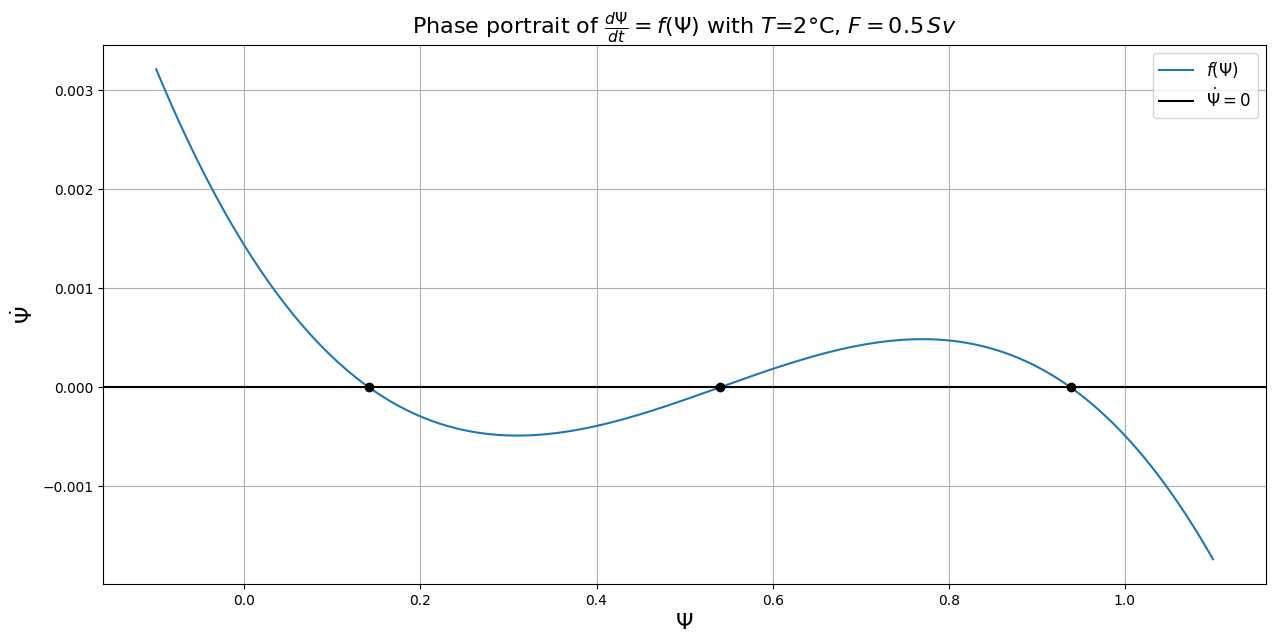

In [367]:
### Computation of the equilibirum points of equation (1) ###

eq_points_1 = fsolve(dPsi_dt, -0.5, args=(T_B, F_A, AMOC_crit_params))
eq_points_2 = fsolve(dPsi_dt, 0.5, args=(T_B, F_A, AMOC_crit_params))
eq_points_3 = fsolve(dPsi_dt, 1.25, args=(T_B, F_A, AMOC_crit_params))

eq_points = [eq_points_1, eq_points_2, eq_points_3]
print(eq_points)

### Plot of the phase portrait Eq.(1) with equilibrium points ###
N = 1000
Psi = np.linspace(-0.1, 1.1, N)
Y = np.zeros(N)
#Z = np.zeros(N)
for i in range(N):
    y = dPsi_dt(Psi[i], T_B, F_A, AMOC_crit_params)
#    z = dPsi_dt_ExpA(Psi[i], T_B, AMOC_crit_params)
    Y[i] = y
#    Z[i] = z
    
fig, ax = plt.subplots(1,1,figsize=(15,7))

ax.plot(Psi, Y, label = r"$f(\Psi)$")
#ax.plot(Psi, Z, label = "ExpA")
plt.axhline(y=0, color="black", label="$\dot{\Psi}=0$")
for i in range(3):
    plt.plot(eq_points[i], dPsi_dt(eq_points[i], T_B, F_A, AMOC_crit_params), "ko")
ax.set_xlabel(r"$\Psi$", fontsize = 16)
ax.set_ylabel(r"$\dot{\Psi}$", fontsize = 16)
ax.set_title("Phase portrait of "+r"$\frac{d\Psi}{dt} = f(\Psi)$"+" with "+r"$T$={}°C,".format(T_B)+r" $F={}\,Sv$".format(F_A), fontsize = 16)
ax.legend(fontsize = 12)
plt.grid()
plt.plot()

##### Bifurcation Diagram

In order to find the bifurcation diagram we will try two differents methods cfr [[Note de Travail - Cadre Algorithmique Coefficients de Couplage]].

The **first method** is to isolate the expression of the forcing consider with respect to the value of the dynamic variable $\Psi$ at equilibrium noted $\psi$. For the **sensitivity experiment A** this relation is equal to
$$ T = (\psi^3-a_1\psi^2-b_1\psi-c_1-e_{12}F_{GIS}^A)\frac{1}{d_1} = T(\psi) \quad (4) $$ 

The idea is to plot this relation and then invert it in order to have the $(\psi, T)$ graph which is our bifurcation diagram.

For the **sensitivity experiment B** this relation is equal to

$$ F_{GIS} = (\psi^3-a_1\psi^2-b_1\psi-c_1-d_1T^B)\frac{1}{e_{12}} \quad (5) $$ 

The **second method** is to define a more general algorithm for finding explicitly the roots of Eq.(1) by iterating the fsolve() function of scipy with different initial conditions in order to get all the roots since we can have up to three roots, three equilibria for the same value of the forcing. This should not be hard to do but since the first method is easier to implement and gives good results I will not take the research further for the moment for the second method.

In [368]:
# Definition of the function folowing Eq.(4) and Eq.(5) # 
def T_funct_psi(psi):
  return ((psi**3 - a*(psi**2) - b*psi - c - e*F_A)*(1/d))

def F_funct_psi(psi):
  return ((psi**3 - a*(psi**2) - b*psi - c - d*T_B)*(1/e))

# Computation of the functions # 
dx=0.01
psi_range = np.arange(-0.2,1.2,dx)
T_fct_psi = T_funct_psi(psi_range)
F_fct_psi = F_funct_psi(psi_range)

# Classification of the unstable branche # 

unstable_psi = np.arange(AMOC_crit_params[1], AMOC_crit_params[0], dx)
T_fct_psi_unstable = T_funct_psi(unstable_psi)
F_fct_psi_unstable = F_funct_psi(unstable_psi)

Plot of the $(\psi, T(\psi))$ graph

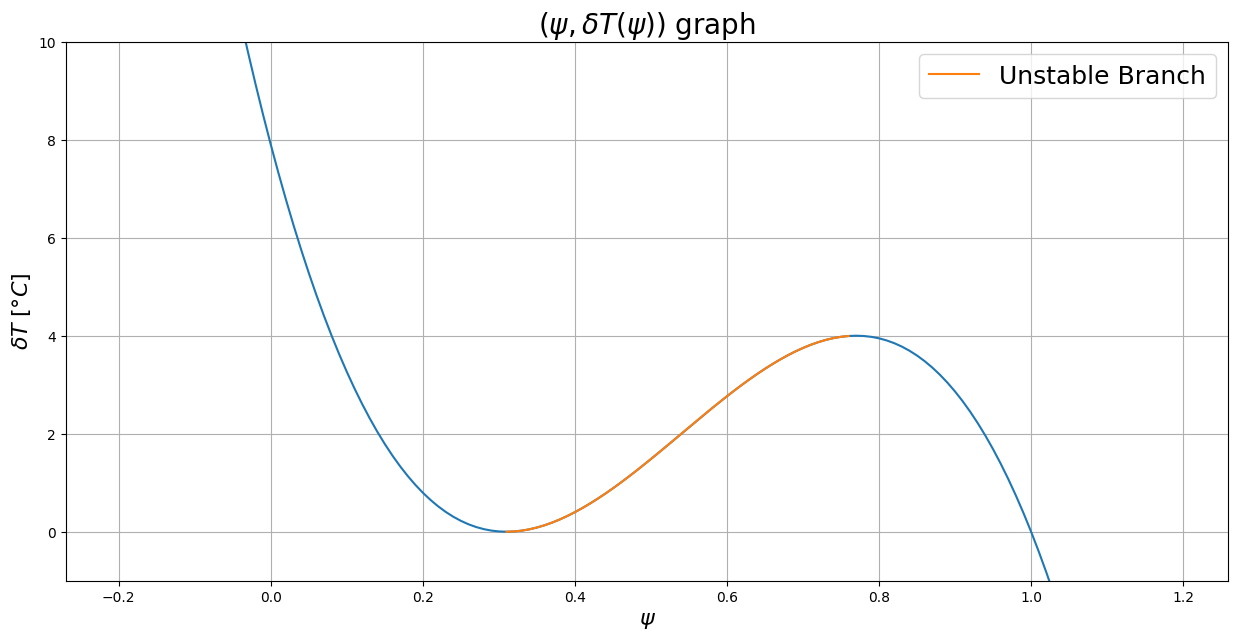

In [369]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(psi_range, T_fct_psi)
plt.plot(unstable_psi, T_fct_psi_unstable, color = "tab:orange", label="Unstable Branch")
ax.set_xlabel(r"$\psi$", fontsize=16)
ax.set_ylabel(r"$\delta T\;[°C]$", fontsize=16)
ax.set_ybound([-1,10])
plt.title(r"$(\psi, \delta T(\psi))$ graph", fontsize = 20)
plt.legend(fontsize=18)
plt.grid()

plt.show()

Plot of the $(T, \psi(T))$ graph - Bifurcation diagram of $\delta T$

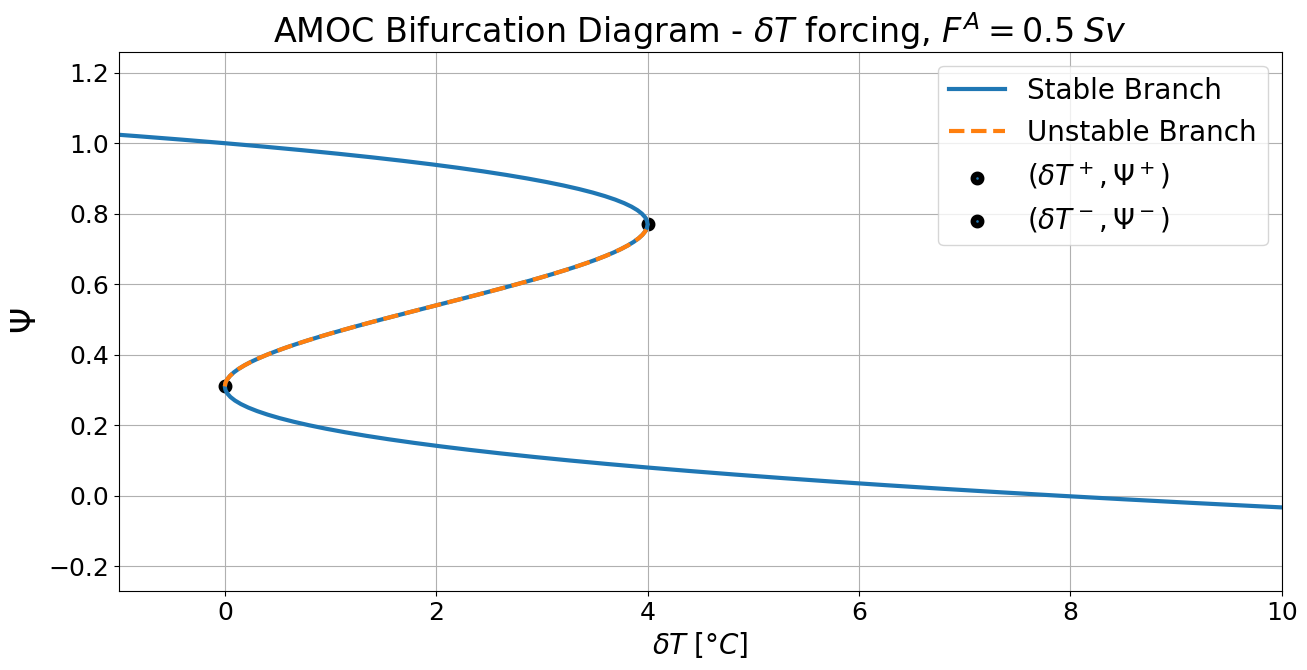

In [370]:
### Plotting ###

fig, ax = plt.subplots(1,1,figsize=(15,7))

## Plot of the bifurcation diagram ##
plt.plot(T_fct_psi, psi_range, label="Stable Branch", lw=3)
plt.plot(T_fct_psi_unstable, unstable_psi, color="tab:orange", label="Unstable Branch", lw=3, linestyle="dashed")

## Plot of the critical points ##
plt.scatter(AMOC_crit_params[2],AMOC_crit_params[0], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(\delta T^+, \Psi^+)$")
plt.scatter(AMOC_crit_params[3],AMOC_crit_params[1], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(\delta T^-, \Psi^-)$")

## Plot cosmetics ##
ax.set_xlabel(r"$\delta T\;[°C]$", fontsize=20)
ax.set_ylabel(r"$\Psi$", fontsize=24)
ax.set_xbound([-1,10])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(r"AMOC Bifurcation Diagram - $\delta T$ forcing, $F^A = {} \;Sv$".format(F_A), fontsize = 24)
plt.legend(fontsize=20)
plt.grid()

plt.show()

Plot of the $(\psi, F_{GIS}(\psi))$ graph

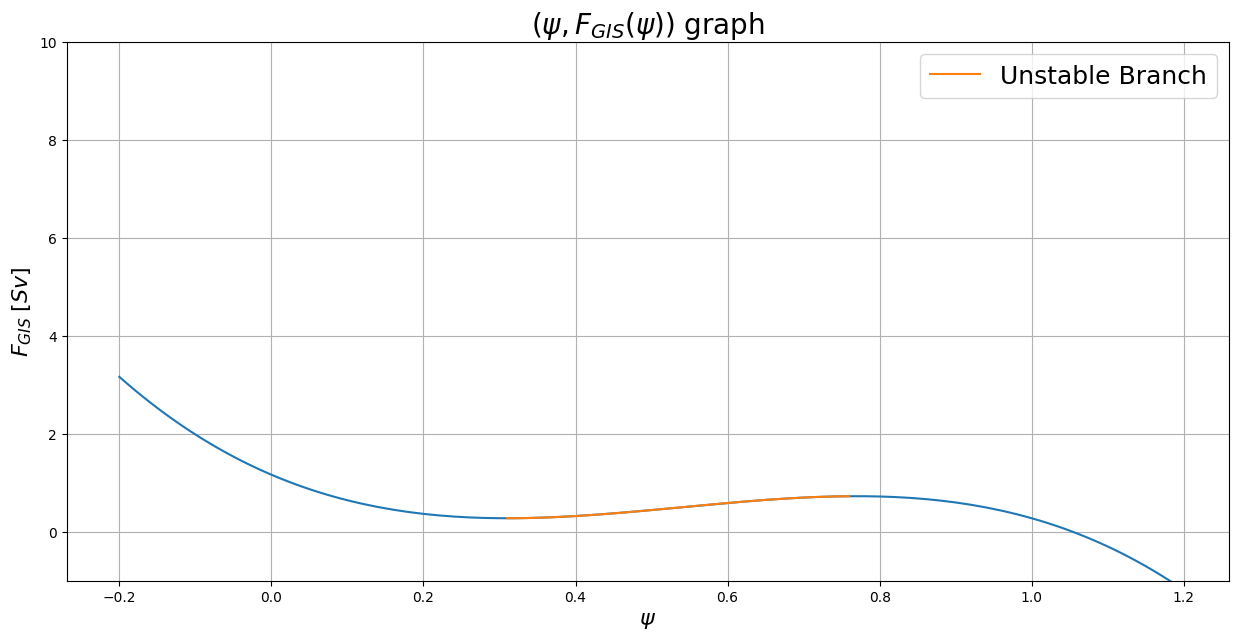

In [371]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

plt.plot(psi_range, F_fct_psi)
plt.plot(unstable_psi, F_fct_psi_unstable, color = "tab:orange", label="Unstable Branch")
ax.set_xlabel(r"$\psi$", fontsize=16)
ax.set_ylabel(r"$F_{GIS}\;[Sv]$", fontsize=16)
ax.set_ybound([-1,10])
plt.title(r"$(\psi, F_{GIS}(\psi))$ graph", fontsize = 20)
plt.legend(fontsize=18)
plt.grid()

plt.show()

Plot of the $(F_{GIS}, \psi(F_{GIS}))$ graph - Bifurcation diagram of $F_{GIS}$

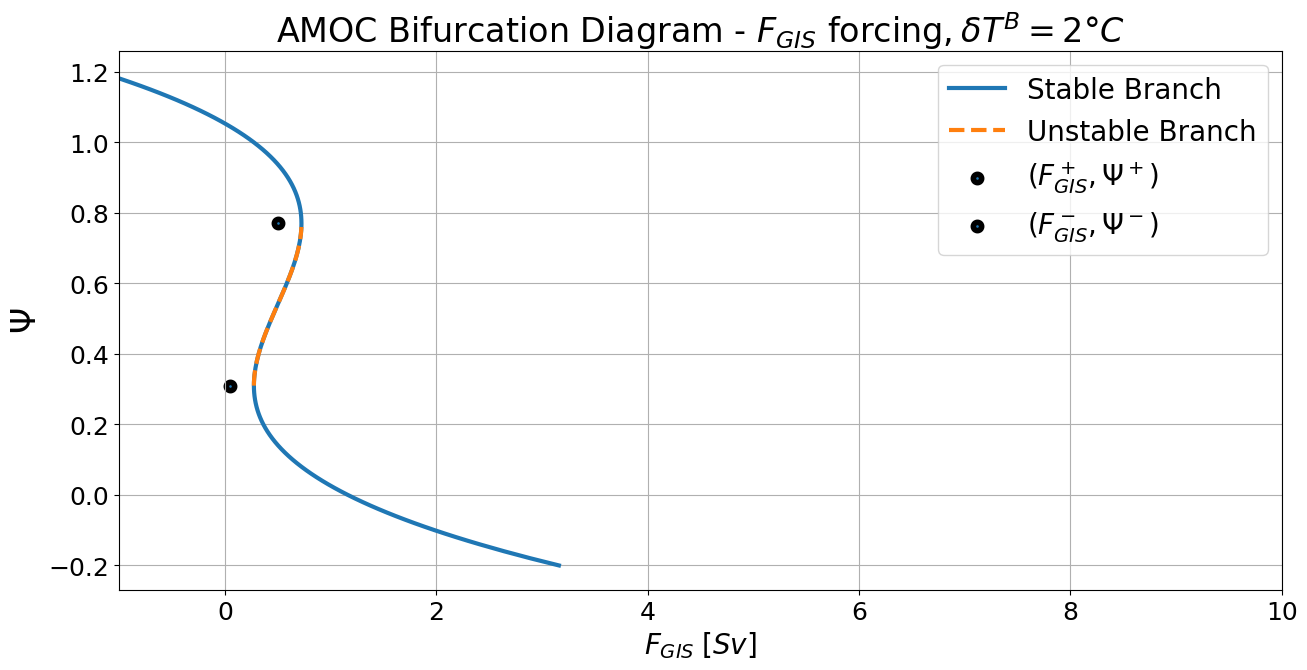

In [372]:
### Plotting ###

fig, ax = plt.subplots(1,1,figsize=(15,7))

## Plot of the bifurcation diagram ##
plt.plot(F_fct_psi, psi_range, label="Stable Branch", lw=3)
plt.plot(F_fct_psi_unstable, unstable_psi, color="tab:orange", label="Unstable Branch", lw=3, linestyle="dashed")

## Plot of the critical points ##
plt.scatter(AMOC_crit_params[4],AMOC_crit_params[0], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(F_{GIS}^+, \Psi^+)$")
plt.scatter(AMOC_crit_params[5],AMOC_crit_params[1], marker='o', color="#1f77b4", linewidths=4, edgecolors="black", label=r"$(F_{GIS}^-, \Psi^-)$")

## Plot cosmetics ##
ax.set_xlabel(r"$F_{GIS}\;[Sv]$", fontsize=20)
ax.set_ylabel(r"$\Psi$", fontsize=24)
ax.set_xbound([-1,10])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(r"AMOC Bifurcation Diagram - $F_{GIS}$ forcing,"+r"$ \:\delta T^B = {}°C$".format(T_B), fontsize = 24)
plt.legend(fontsize=20)
plt.grid()

plt.show()